In [96]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
from scipy import sparse
import random

import seaborn as sns

import qiskit
from qutip import *
from qiskit import (
    QuantumCircuit, QuantumRegister, ClassicalRegister, Aer,
    execute
)
from qiskit.tools.visualization import plot_histogram
from numpy import pi
import time

In [97]:
def gridCreator(size):
    grid = np.ones((size,size))
    grid[0][0] = 2
    grid[size-1][size-1] = 3
    costDict = {}
    for i in range(1,len(grid)-2,2):
        numObs = random.randint(0,len(grid)-1)
        for j in range(numObs):
            notPlaced = True
            while notPlaced:
                y = random.randint(0,len(grid)-1)
                if grid[y][i] != 0:
                    grid[y][i] = 0
                    notPlaced = False
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            costDict[(i,j)] = random.randint(1,4)
    return (grid,costDict)

In [126]:
def gridCreatorNoObs(size):
    grid = np.ones((size,size))
    grid[0][0] = 2
    grid[size-1][size-1] = 3
    costDict = {}
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            costDict[(i,j)] = 1
    return (grid,costDict)

In [98]:
gridTest,costDict = gridCreator(10)

In [99]:
def manhattanDist(start,end):
    return (abs(start[0] - end[0]) + abs(start[1] - end[1]))

In [100]:
def getActions(grid,curLoc,evaledSet):
    size = len(grid)
    startY = curLoc[0]
    startX = curLoc[1]
    up = (startY-1,startX)
    down = (startY+1,startX)
    left = (startY,startX-1)
    right = (startY,startX+1)
    possActs = [up,down,left,right]
    finalActs = []
    for act in possActs:
        if act not in evaledSet:
            if act[0] >= 0 and act[0] < size:
                if act[1] >= 0 and act[1] < size:
                    if grid[act] != 0:
                        finalActs.append(act)
    return finalActs

In [101]:
def cost(start,end):
    return 1

In [102]:
def bInsert(pQueue,elt,totalCost,allCosts):
    if len(pQueue) == 0:
        return [elt]
    middle = int(len(pQueue)/2)
    if totalCost > allCosts[pQueue[middle]]:
        return (pQueue[:(middle+1)] + bInsert(pQueue[(middle+1):],elt,totalCost,allCosts))
    elif totalCost < allCosts[pQueue[middle]]:
        return (bInsert(pQueue[:middle],elt,totalCost,allCosts) + pQueue[middle:])
    else:
        return (pQueue[:middle] + [elt] + pQueue[middle:])

In [103]:
def aStarSearch(grid,costDict):
    costIncurred = 0
    curLoc = (0,0)
    start = (0,0)
    end = (len(grid)-1,len(grid)-1)
    evaledSet = set()
    possibleSet = [start]
    paths = {}
    costs = {}
    totalCostHeuristic = {}
    removals = 0
    insertions = 0
    for i in range(len(grid)):
        for j in range(len(grid)):
            costs[(i,j)] = -1
            totalCostHeuristic[(i,j)] = -1
            paths[(i,j)] = None
    costs[start] = 0
    totalCostHeuristic[start] = manhattanDist(start,end)
    while len(possibleSet) > 0:
        curLoc = possibleSet[0]
        removals += 1
        if curLoc == end: 
            return (paths,insertions,removals)
        del possibleSet[0]
        evaledSet.add(curLoc)
        newPossibleLocs = getActions(grid,curLoc,evaledSet)
        for loc in newPossibleLocs:
            totalCostAccum = costs[curLoc] + costDict[loc]
            if loc not in possibleSet:
                insertions += 1
                paths[loc] = curLoc
                heurLeft = manhattanDist(loc,end)
                possibleSet = bInsert(possibleSet,loc,totalCostAccum+heurLeft,totalCostHeuristic)
                costs[loc] = totalCostAccum
                totalCostHeuristic[loc] = totalCostAccum+heurLeft
            else:
                if totalCostAccum < costs[loc]:
                    insertions += 1
                    possibleSet.remove(loc)
                    heurLeft = manhattanDist(loc,end)
                    possibleSet = bInsert(possibleSet,loc,totalCostAccum+heurLeft,totalCostHeuristic)
                    costs[loc] = totalCostAccum
                    totalCostHeuristic[loc] = totalCostAccum+heurLeft
                    paths[loc] = curLoc
            

In [104]:
def findOptimalPath(paths,end,start):
    path = [end]
    curLoc = end
    while curLoc != start:
        path = [paths[curLoc]] + path
        curLoc = paths[curLoc]
    return(path)

In [105]:
#Sams attempt to generaliz cccz
n = 5

# initalize reigesters
qr = QuantumRegister(n)
c = ClassicalRegister(n)

# initialize circuit
qc = QuantumCircuit(qr, c)

# add an X-gate to the quantum register

piFrac = pi/(2 ** (n-1))
qc.rz(piFrac, qr[0])
for i in range(1,n):
    for j in range(2):
        if i > 1:
            for k in range(2*(i-1)):
                if k % 2 == 0:
                    qc.cx(qr[i-int(k/2)-1],qr[i])
                    print("Control: " + str(i-(k/2)-1) + " Target: " + str(i))
                    qc.rz(-piFrac,qr[i])
                else:
                    print("Control: " + str(0) + " Target: " + str(i))
                    qc.cx(qr[0],qr[i])
                    qc.rz(piFrac,qr[i])
                #if j == 0:
                    #qc.rz(-piFrac,qr[i])
                #else:
                    #qc.rz(piFrac,qr[i])
        else:
            for k in range(i):
                #qc.cx(qr[i-1+k],qr[i+k])
                if j == 0:
                    print("Here1Control: " + str(0) + " Target: " + str(i))
                    qc.cx(qr[0],qr[i])
                    qc.rz(-piFrac,qr[i])
                else:
                    print("Here2Control: " + str(0) + " Target: " + str(i))
                    qc.cx(qr[0],qr[i])
                    qc.rz(piFrac,qr[i])
simulator = Aer.get_backend('unitary_simulator')

result = execute(qc, simulator).result()
unitary = result.get_unitary(qc)
print("Circuit unitary:\n", unitary[31])



Here1Control: 0 Target: 1
Here2Control: 0 Target: 1
Control: 1.0 Target: 2
Control: 0 Target: 2
Control: 1.0 Target: 2
Control: 0 Target: 2
Control: 2.0 Target: 3
Control: 0 Target: 3
Control: 1.0 Target: 3
Control: 0 Target: 3
Control: 2.0 Target: 3
Control: 0 Target: 3
Control: 1.0 Target: 3
Control: 0 Target: 3
Control: 3.0 Target: 4
Control: 0 Target: 4
Control: 2.0 Target: 4
Control: 0 Target: 4
Control: 1.0 Target: 4
Control: 0 Target: 4
Control: 3.0 Target: 4
Control: 0 Target: 4
Control: 2.0 Target: 4
Control: 0 Target: 4
Control: 1.0 Target: 4
Control: 0 Target: 4
Circuit unitary:
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        

In [106]:
n = 6

# initalize reigesters
qr = QuantumRegister(n)
c = ClassicalRegister(n)

# initialize circuit
qc = QuantumCircuit(qr, c)

# add an X-gate to the quantum register

piFrac = np.pi/(2 ** (n-1))
qc.rz(piFrac, qr[0])

qc.cx(qr[0], qr[1])
qc.rz(-piFrac, qr[1])
qc.cx(qr[0], qr[1])
qc.rz(piFrac, qr[1])

def pattern(maxi, iterator, curList):
    if iterator == maxi:
        return curList
    else:
        midList = curList+[iterator]+curList
        qc.cx(qr[iterator], qr[iterator+1])
        qc.rz(-piFrac, qr[iterator+1])
        for i in range(len(midList)):
            qc.cx(qr[midList[i]], qr[iterator+1])
            if i % 2 == 0:
                qc.rz(piFrac, qr[iterator+1])
            else:
                qc.rz(-piFrac, qr[iterator+1])

        return pattern(maxi, iterator+1, curList+[iterator]+curList)

curPattern = pattern(n-1, 1, [0])

simulator = Aer.get_backend('unitary_simulator')

result = execute(qc, simulator).result()
unitary = result.get_unitary(qc)
print("Circuit unitary:\n", unitary)

Circuit unitary:
 [[ 1.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j -1.+0.j]]


In [107]:
def pattern(maxi, iterator, curList,qc,qr,piFrac):
    if iterator == maxi:
        return curList
    else:
        midList = curList+[iterator]+curList
        qc.cx(qr[iterator], qr[iterator+1])
        qc.rz(-piFrac, qr[iterator+1])
        for i in range(len(midList)):
            qc.cx(qr[midList[i]], qr[iterator+1])
            if i % 2 == 0:
                qc.rz(piFrac, qr[iterator+1])
            else:
                qc.rz(-piFrac, qr[iterator+1])
        return pattern(maxi, iterator+1, curList+[iterator]+curList,qc,qr,piFrac)

In [108]:
def createGroverOracle(toMark,n,piFrac):
    qr = QuantumRegister(n)
    c = ClassicalRegister(n)

    # initialize circuit
    qc = QuantumCircuit(qr, c)
    for elt in toMark:
        binary = np.binary_repr(elt)
        diff = n - len(binary)
        for h in range(diff):
            binary = "0" + binary
        for i in range(len(binary)):
            if binary[::-1][i] == "0":
                qc.x(qr[int(i)])
        qc.rz(piFrac, qr[0])
        if n > 1:
            qc.cx(qr[0], qr[1])
            qc.rz(-piFrac, qr[1])
            qc.cx(qr[0], qr[1])
            qc.rz(piFrac, qr[1])
        if n > 2:
            pattern(n-1,1,[0],qc,qr,piFrac)

        for i in range(len(binary)):
            if binary[::-1][i] == "0":
                qc.x(qr[int(i)])
    return qc

In [109]:
def groverSearchMin(lst,costs,numChecks):
    oracleTime = 0
    n = int(np.ceil(np.log2(len(lst))))
    y = random.randint(0,len(lst)-1)
    minNotFound = True
    checks = 0
    while minNotFound:
        qr = QuantumRegister(n)
        c = ClassicalRegister(n)
        # initialize circuit
        qc = QuantumCircuit(qr, c)
        toMark = []
        markStart = time.time()
        for i in range(len(lst)):
            if costs[lst[i]] < costs[lst[y]]:
                toMark.append(i)
        markEnd = time.time()
        markTime = markEnd - markStart
        for i in range(n):
            qc.h(qr[i])
        piFrac = np.pi/(2 ** (n-1))
        if len(toMark) == 0:
            return ((y,oracleTime,n))
        iterations = int(np.pi/4 * ((n/len(toMark))**.5))
        oracleStart = time.time()
        for m in range(iterations):
            for elt in toMark:
                binary = np.binary_repr(elt)
                diff = n - len(binary)
                for h in range(diff):
                    binary = "0" + binary
                for i in range(len(binary)):
                    if binary[::-1][i] == "0":
                        qc.x(qr[int(i)])
                qc.rz(piFrac, qr[0])
                if n > 1:
                    qc.cx(qr[0], qr[1])
                    qc.rz(-piFrac, qr[1])
                    qc.cx(qr[0], qr[1])
                    qc.rz(piFrac, qr[1])
                if n > 2:
                    pattern(n-1,1,[0],qc,qr,piFrac)

                for i in range(len(binary)):
                    if binary[::-1][i] == "0":
                        qc.x(qr[int(i)])
            for i in range(n):
                qc.h(qr[i])
                qc.x(qr[i])

        qc.rz(piFrac, qr[0])
        if n > 1:
            qc.cx(qr[0], qr[1])
            qc.rz(-piFrac, qr[1])
            qc.cx(qr[0], qr[1])
            qc.rz(piFrac, qr[1])
        if n > 2:
            pattern(n-1,1,[0],qc,qr,piFrac)
        for i in range(n):
            qc.x(qr[i])
            qc.h(qr[i])
        for i in range(n):
            qc.measure(qr[i],c[i])
        oracleEnd = time.time()
        oracleTime += (oracleEnd - oracleStart)
        simulator = Aer.get_backend('qasm_simulator')
        results = execute(qc, simulator,shots = 1).result()
        result = list((results.get_counts(qc)).keys())[0]
        newY = int(result,2)
        if newY < len(lst):
            if costs[lst[newY]] < costs[lst[y]]:
                y = newY
        checks += 1
        if (checks >= numChecks):
            minNotFound = False
    return ((y,oracleTime,n))

In [110]:
def quantumAStarSearch(grid,numChecks,costDict):
    removals = 0
    insertions = 0
    costIncurred = 0
    curLoc = (0,0)
    start = (0,0)
    end = (len(grid)-1,len(grid)-1)
    evaledSet = set()
    possibleSet = [start]
    paths = {}
    costs = {}
    totalCostHeuristic = {}
    oracleTime = 0
    qubitList = []
    removals = 0
    insertions = 0
    for i in range(len(grid)):
        for j in range(len(grid)):
            costs[(i,j)] = -1
            totalCostHeuristic[(i,j)] = -1
            paths[(i,j)] = None
    costs[start] = 0
    totalCostHeuristic[start] = manhattanDist(start,end)
    while len(possibleSet) > 0:
        if len(possibleSet) > 1:
            groverRet = groverSearchMin(possibleSet,totalCostHeuristic,numChecks)
            curLoc = possibleSet[groverRet[0]]
            oracleTime += groverRet[1]
            qubitList.append(groverRet[2])
        else:
            curLoc = possibleSet[0]
        if curLoc == end: 
            return ((paths, oracleTime,qubitList,insertions,removals))
        possibleSet.remove(curLoc)
        removals += 1
        evaledSet.add(curLoc)
        newPossibleLocs = getActions(grid,curLoc,evaledSet)
        for loc in newPossibleLocs:
            totalCostAccum = costs[curLoc] + costDict[loc]
            if loc not in possibleSet:
                insertions += 1
                paths[loc] = curLoc
                heurLeft = manhattanDist(loc,end)
                possibleSet.append(loc)
                costs[loc] = totalCostAccum
                totalCostHeuristic[loc] = totalCostAccum+heurLeft
            else:
                if totalCostAccum < costs[loc]:
                    heurLeft = manhattanDist(loc,end)
                    costs[loc] = totalCostAccum
                    totalCostHeuristic[loc] = totalCostAccum+heurLeft
                    paths[loc] = curLoc
            

In [111]:
def gridPrint(grid):
    string = " "
    for i in range(len(grid[0])+1):
        string += "--"
    string += "\n"
    for i in range(len(grid)):
        string += "| "
        for j in range(len(grid[i])):
            if grid[i][j] == 2.:
                string += "S "
            if grid[i][j] == 1.:
                string += "  "
            if grid[i][j] == 3.:
                string += "E "
            if grid[i][j] == 0.:
                string += "X "
        string += " |\n"
    string += " "
    for i in range(len(grid[0])+1):
        string += "--"
    return(string)

In [112]:
def printGridPath(path,grid):
    string = " "
    for i in range(len(grid[0])+1):
        string += "--"
    string += "\n"
    for i in range(len(grid)):
        string += "| "
        for j in range(len(grid[i])):
            if grid[i][j] == 2.:
                string += "S "
            elif grid[i][j] == 3.:
                string += "E "
            elif (i,j) in path:
                string += ". "
            elif grid[i][j] == 1.:
                string += "  "
            elif grid[i][j] == 0.:
                string += "X "
        string += " |\n"
    string += " "
    for i in range(len(grid[0])+1):
        string += "--"
    return(string)

In [113]:
def getPathCost(path,gridCosts):
    cost = 0
    for loc in path:
        cost += gridCosts[loc]
    return cost

In [187]:
grids = []
costs = []
for i in range(5,11):
    for j in range(5):
        grid,cost = gridCreator(i)
        grids.append(grid)
        costs.append(cost)

In [188]:
quantumTotalTimes = []
quantumCircuitCreationTimes = []
quantumPaths = []
qubitCounts = []
quantumNodesEvaluated = []
quantumPathCosts = []
gridStrings = []
quantumPathStrings = []
quantumInsertions = []
quantumRemovals = []
quantumChecks = []
for i in range(len(grids)):
    grid = grids[i]
    cost = costs[i]
    quantumTotalTimesGrid = []
    quantumCircuitCreationTimesGrid = []
    quantumPathsGrid = []
    qubitCountsGrid = []
    quantumNodesEvaluatedGrid = []
    quantumPathCostsGrid = []
    gridStringsGrid = []
    quantumPathStringsGrid = []
    quantumInsertionsGrid = []
    quantumRemovalsGrid = []
    quantumChecksGrid = []
    for j in range(1,10):
        quantumStart = time.time()
        quantumPath,circuitTime,qubitList,quantumInserion,quantumRemoval = quantumAStarSearch(grid,j,cost)
        qubitCountsGrid.append(qubitList)
        quantumEnd = time.time()
        quantumNodeCount = 0
        for key,value in quantumPath.items():
            if value != None:
                quantumNodeCount += 1
        quantumNodesEvaluatedGrid.append(quantumNodeCount)
        quantumTotalTime = quantumEnd - quantumStart
        quantumTotalTimesGrid.append(quantumTotalTime)
        quantumCircuitCreationTimesGrid.append(circuitTime)
        quantumOptPath = findOptimalPath(quantumPath,(len(grid)-1,len(grid)-1),(0,0))
        quantumPathsGrid.append(quantumOptPath)
        quantumPathCostsGrid.append(getPathCost(quantumOptPath,cost))
        gridStringsGrid.append(gridPrint(grid))
        quantumPathStringsGrid.append(printGridPath(quantumOptPath,grid))
        quantumInsertionsGrid.append(quantumInsertion)
        quantumRemovalsGrid.append(quantumRemoval)
        quantumChecksGrid.append(j)
    quantumInsertions.append(quantumInsertionsGrid)
    quantumChecks.append(quantumChecksGrid)
    quantumRemovals.append(quantumRemovalsGrid)
    quantumTotalTimes.append(quantumTotalTimesGrid)
    quantumCircuitCreationTimes.append(quantumCircuitCreationTimesGrid)
    quantumPaths.append(quantumPathsGrid)
    qubitCounts.append(qubitCountsGrid)
    quantumNodesEvaluated.append(quantumNodesEvaluatedGrid)
    quantumPathCosts.append(quantumPathCostsGrid)
    gridStrings.append(gridStringsGrid)
    quantumPathStrings.append(quantumPathStringsGrid)

In [ ]:

for i in range(len(quantumChecksGrid)):
    for j in range(len(quantumChecksGrid[i]))
        

In [171]:
grids = []
costs = []
for i in range(5):
    for j in range(5,16):
        grid,cost = gridCreator(j)
        grids.append(grid)
        costs.append(cost)

In [172]:
standardTimes = []
quantumTotalTimes = []
quantumCircuitCreationTimes = []
standardPaths = []
quantumPaths = []
qubitCounts = []
quantumNodesEvaluated = []
standardNodesEvaluated = []
quantumPathCosts = []
standardPathCosts = []
gridStrings = []
quantumPathStrings = []
standardPathStrings = []
standardInsertions = []
standardRemovals = []
quantumInsertions = []
quantumRemovals = []
for i in range(len(grids)):
    grid = grids[i]
    cost = costs[i]
    standardStart = time.time()
    standardPath,standardInsertion,standardRemoval = aStarSearch(grid,cost)
    standardEnd = time.time()
    standardNodeCount = 0
    for key,value in standardPath.items():
        if value != None:
            standardNodeCount += 1
    standardNodesEvaluated.append(standardNodeCount)
    standardTime = standardEnd-standardStart
    standardOptPath = findOptimalPath(standardPath,(len(grid)-1,len(grid)-1),(0,0))
    standardTimes.append(standardTime)
    standardPaths.append(standardOptPath)
    standardInsertions.append(standardInsertion)
    standardRemovals.append(standardRemoval)
    quantumStart = time.time()
    quantumPath,circuitTime,qubitList,quantumInsertion,quantumRemoval = quantumAStarSearch(grid,3,cost)
    qubitCounts.append(qubitList)
    quantumEnd = time.time()
    quantumNodeCount = 0
    for key,value in quantumPath.items():
        if value != None:
            quantumNodeCount += 1
    quantumNodesEvaluated.append(quantumNodeCount)
    quantumTotalTime = quantumEnd - quantumStart
    quantumTotalTimes.append(quantumTotalTime)
    quantumCircuitCreationTimes.append(circuitTime)
    quantumOptPath = findOptimalPath(quantumPath,(len(grid)-1,len(grid)-1),(0,0))
    quantumPaths.append(quantumOptPath)
    quantumPathCosts.append(getPathCost(quantumOptPath,cost))
    standardPathCosts.append(getPathCost(standardOptPath,cost))
    quantumInsertions.append(quantumInsertion)
    quantumRemovals.append(quantumRemoval)
    gridStrings.append(gridPrint(grid))
    quantumPathStrings.append(printGridPath(quantumOptPath,grid))
    standardPathStrings.append(printGridPath(standardOptPath,grid))

In [ ]:
for i in range(len())

In [166]:
gridLengths = []
for i in range(len(grids)):
    gridLengths.append(len(grids[i]))

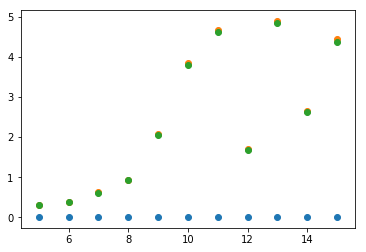

In [167]:
plt.scatter(gridLengths,standardTimes)
plt.scatter(gridLengths,quantumTotalTimes)
plt.scatter(gridLengths,[quantumTotalTimes[i] - quantumCircuitCreationTimes[i] for i in range(len(quantumTotalTimes))])
plt.show()

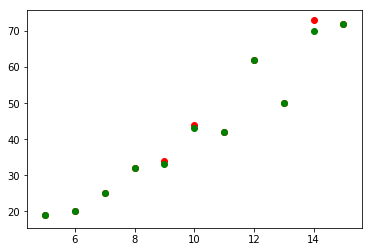

In [169]:
plt.scatter(gridLengths,quantumPathCosts,color = "red")
plt.scatter(gridLengths,standardPathCosts,color = "green")
plt.show()

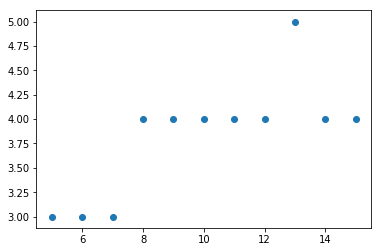

In [170]:
plt.scatter(gridLengths,[max(qubitCount) for qubitCount in qubitCounts])
plt.show()

[ 7.09090909 12.27272727 16.72727273 21.54545455 22.18181818 22.54545455
 42.54545455 49.54545455 58.         65.         61.90909091]


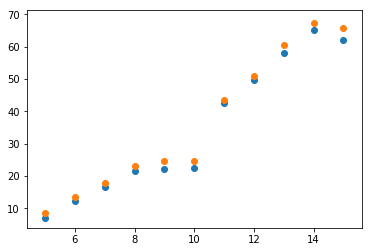

In [186]:
avgInsertions = []
avgRemovals = []
count = 0
removalAvg = np.zeros(11)
insertionAvg = np.zeros(11)
for i in range(5):
    innerCount = 0
    for j in range(5,16):
        removalAvg[j-5] += quantumRemovals[count]
        insertionAvg[j-5] += quantumInsertions[count]
        count += 1
print(removalAvg/11)
plt.scatter(gridLengths,removalAvg/11)
plt.scatter(gridLengths,insertionAvg/11)
plt.show()

In [115]:
def costDictToArray(costDict):
    size = int(np.sqrt(len(costDict)))
    array = np.ones((size,size))
    for key,value in costDict.items():
        array[key[1]][key[0]] = value
    return array

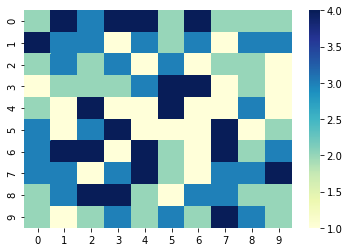

In [338]:
cost = costDictToArray(costs[27])
ax = sns.heatmap(cost,cmap = "YlGnBu")

# Demo Section

In [131]:
demoGridNoObs, demoCostsNoObs = gridCreatorNoObs(12)

In [132]:
print(gridPrint(demoGridNoObs))

 --------------------------
| S                        |
|                          |
|                          |
|                          |
|                          |
|                          |
|                          |
|                          |
|                          |
|                          |
|                          |
|                       E  |
 --------------------------


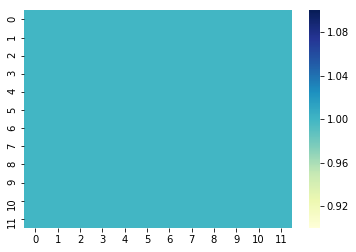

In [133]:
cost = costDictToArray(demoCostsNoObs)
ax = sns.heatmap(cost,cmap = "YlGnBu")

In [134]:
demoGrid, demoCosts = gridCreator(12)

In [135]:
print(gridPrint(demoGrid))

 --------------------------
| S     X                  |
|       X           X      |
|   X   X       X          |
|       X                  |
|                          |
|       X   X   X   X      |
|       X       X          |
|       X   X   X   X      |
|                   X      |
|       X                  |
|       X                  |
|       X       X       E  |
 --------------------------


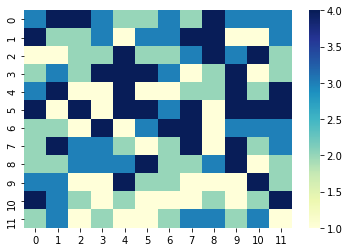

In [136]:
cost = costDictToArray(demoCosts)
ax = sns.heatmap(cost,cmap = "YlGnBu")

In [137]:
quantumPath,circuitTime,qubitList,quantumInsertion,quantumRemoval = quantumAStarSearch(demoGrid,1,demoCosts)

In [138]:
standardPath,standardInsertion,standardRemoval = aStarSearch(demoGrid,demoCosts)

In [156]:
quantumOptPath = findOptimalPath(quantumPath,(len(demoGrid)-1,len(demoGrid)-1),(0,0))
print(printGridPath(quantumOptPath,demoGrid))

 --------------------------
| S . . X                  |
|     . X           X      |
|   X . X       X          |
|     . X                  |
|     . . .                |
|       X . X   X   X      |
|       X .     X          |
|       X . X   X   X      |
|         . . . . . X      |
|       X         . . . .  |
|       X               .  |
|       X       X       E  |
 --------------------------


In [140]:
standardOptPath = findOptimalPath(standardPath,(len(demoGrid)-1,len(demoGrid)-1),(0,0))
print(printGridPath(standardOptPath,demoGrid))

 --------------------------
| S . . X                  |
|     . X           X      |
|   X . X       X          |
|     . X                  |
|     . . .                |
|       X . X   X   X      |
|       X .     X          |
|       X . X   X   X      |
|         . . . . . X      |
|       X         . . . .  |
|       X               .  |
|       X       X       E  |
 --------------------------


In [157]:
print(getPathCost(quantumOptPath,demoCosts))
print(getPathCost(standardOptPath,demoCosts))

49
49


In [160]:
quantumPath,circuitTime,qubitList,quantumInsertion,quantumRemoval = quantumAStarSearch(demoGrid,2,demoCosts)
quantumOptPath = findOptimalPath(quantumPath,(len(demoGrid)-1,len(demoGrid)-1),(0,0))
print(printGridPath(quantumOptPath,demoGrid))
print(getPathCost(quantumOptPath,demoCosts))

 --------------------------
| S . . X                  |
|     . X           X      |
|   X . X       X          |
|     . X                  |
|     . . .                |
|       X . X   X   X      |
|       X .     X          |
|       X . X   X   X      |
|         . . . . . X      |
|       X         . . .    |
|       X             .    |
|       X       X     . E  |
 --------------------------
50


In [159]:
quantumPath,circuitTime,qubitList,quantumInsertion,quantumRemoval = quantumAStarSearch(demoGrid,4,demoCosts)
quantumOptPath = findOptimalPath(quantumPath,(len(demoGrid)-1,len(demoGrid)-1),(0,0))
print(printGridPath(quantumOptPath,demoGrid))
print(getPathCost(quantumOptPath,demoCosts))

 --------------------------
| S . . X                  |
|     . X           X      |
|   X . X       X          |
|     . X                  |
|     . . .                |
|       X . X   X   X      |
|       X .     X          |
|       X . X   X   X      |
|         . . . . . X      |
|       X         . . . .  |
|       X               .  |
|       X       X       E  |
 --------------------------
49


In [147]:
piFrac = np.pi/(2 ** (7-1))
qcTest = createGroverOracle([1],7,piFrac)

In [148]:
oracle = qcTest.draw(output = "mpl")
simulator = Aer.get_backend('unitary_simulator')

result = execute(qcTest, simulator).result()
unitary = result.get_unitary(qcTest)
print("Circuit unitary:\n", unitary)

Circuit unitary:
 [[ 1.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  1.+0.j]]


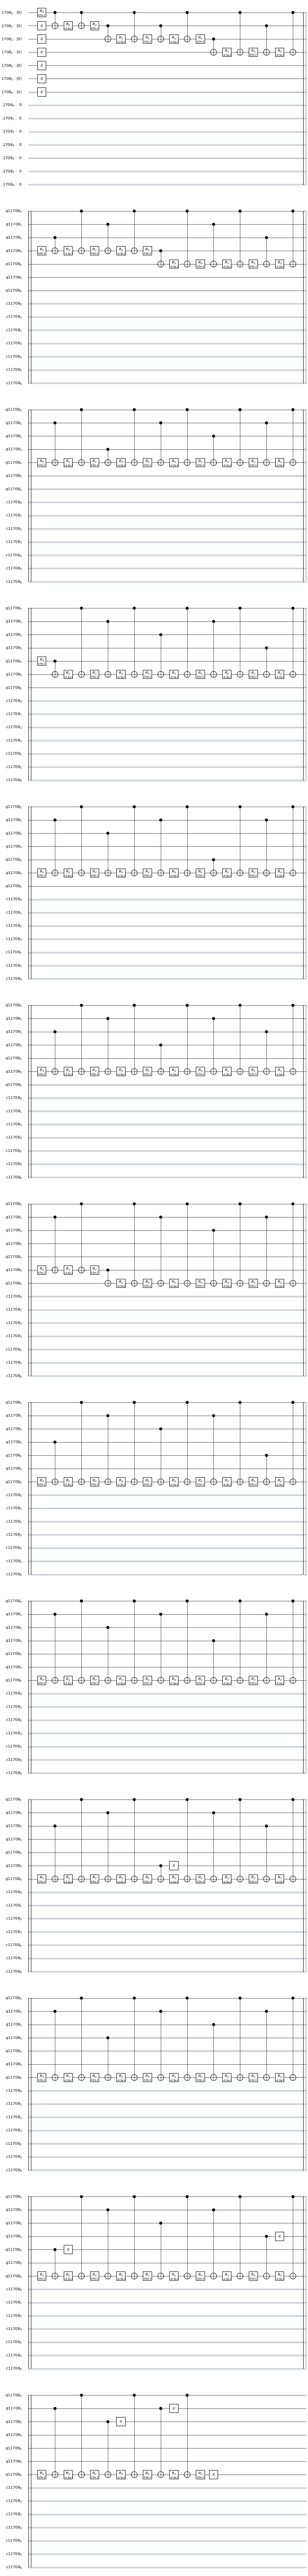

In [149]:
oracle